In [1]:
# imports

import os
import glob
from dotenv import load_dotenv
import gradio as gr

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# imports for langchain and Chroma and plotly

from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma
import numpy as np
from sklearn.manifold import TSNE
import plotly.graph_objects as go

In [3]:
!C:\Users\LENOVO\AppData\Local\Programs\Python\Python310\python.exe -m pip install nbformat





You should consider upgrading via the 'C:\Users\LENOVO\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [4]:
# price is a factor for our company, so we're going to use a low cost model

MODEL = "gpt-4o-mini"
db_name = "vector_db"

In [5]:
# Load environment variables in a file called .env

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')

In [6]:
from langchain_community.document_loaders import DirectoryLoader, PyPDFLoader

# Path relative to your current working directory
folder = "data_ingestion/mosdac_data/documents"

# Load all PDF files using PyPDFLoader
loader = DirectoryLoader(
    path=folder,
    glob="**/*.pdf",             # Make sure this is *.pdf, not *.md
    loader_cls=PyPDFLoader
)

documents = loader.load()
print(f"✅ Total documents loaded: {len(documents)}")


Multiple definitions in dictionary at byte 0x30f8cb for key /Im1027
Multiple definitions in dictionary at byte 0x30f8dc for key /Im1027


✅ Total documents loaded: 1265


In [7]:
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(documents)

In [8]:
len(chunks)


1254

In [9]:
print(chunks[0].metadata)


{'producer': 'Nitro PDF PrimoPDF', 'creator': 'PrimoPDF http://www.primopdf.com', 'creationdate': '2012-03-20T14:49:18-05:30', 'moddate': '2012-03-20T14:49:18-05:30', 'title': 'Microsoft Word - Analysed-Winds', 'author': 'admin', 'source': 'data_ingestion\\mosdac_data\\documents\\Analysed-Winds.pdf', 'total_pages': 6, 'page': 0, 'page_label': '1'}


In [10]:
# Put the chunks of data into a Vector Store that associates a Vector Embedding with each chunk

embeddings = OpenAIEmbeddings()

# If you would rather use the free Vector Embeddings from HuggingFace sentence-transformers
# Then replace embeddings = OpenAIEmbeddings()
# with:
# from langchain.embeddings import HuggingFaceEmbeddings
# embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

In [11]:
# Check if a Chroma Datastore already exists - if so, delete the collection to start from scratch

if os.path.exists(db_name):
    Chroma(persist_directory=db_name, embedding_function=embeddings).delete_collection()

In [12]:
from langchain.vectorstores import Chroma
import math

# Create empty Chroma vectorstore
vectorstore = Chroma(
    persist_directory=db_name,
    embedding_function=embeddings
)

# Batch size to avoid token limit
batch_size = 200

# Total number of chunks
total_chunks = len(chunks)

# Upload in batches
for i in range(0, total_chunks, batch_size):
    batch = chunks[i:i+batch_size]
    vectorstore.add_documents(batch)
    print(f"✅ Uploaded batch {i//batch_size + 1}/{math.ceil(total_chunks/batch_size)}")

# Final vector count
print(f"\n🎉 Vectorstore now has {vectorstore._collection.count()} documents")


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8620\1518526149.py:5: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(


✅ Uploaded batch 1/7
✅ Uploaded batch 2/7
✅ Uploaded batch 3/7
✅ Uploaded batch 4/7
✅ Uploaded batch 5/7
✅ Uploaded batch 6/7
✅ Uploaded batch 7/7

🎉 Vectorstore now has 1254 documents


In [13]:
collection = vectorstore._collection
sample_embedding = collection.get(limit=1, include=["embeddings"])["embeddings"][0]
dimensions = len(sample_embedding)
print(f"The vectors have {dimensions:,} dimensions")


The vectors have 1,536 dimensions


In [14]:
# Prework
result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']


In [15]:
# Extract doc_type from file name (e.g., 'Analysed-Winds.pdf' → 'analysed')
doc_types = [metadata['source'].split('\\')[-1].split('-')[0].lower() for metadata in result['metadatas']]

# Define color map
color_map = {
    'analysed': 'blue',
    'winds': 'green',
    # Add more based on your actual file naming
}

# Assign colors to each document type
colors = [color_map.get(doc_type, 'gray') for doc_type in doc_types]


c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


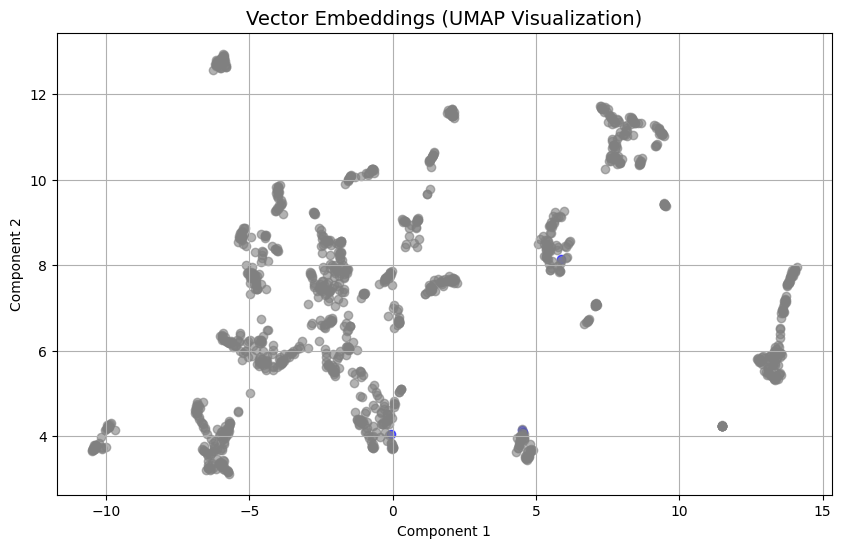

In [16]:
import umap
import matplotlib.pyplot as plt

# Reduce to 2D
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
vectors_2d = reducer.fit_transform(vectors)

# Plot
plt.figure(figsize=(10, 6))
for i, point in enumerate(vectors_2d):
    plt.scatter(point[0], point[1], color=colors[i], alpha=0.6)

plt.title("Vector Embeddings (UMAP Visualization)", fontsize=14)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()


In [17]:
from sklearn.manifold import TSNE
import plotly.graph_objects as go

# Apply t-SNE to reduce to 3D
tsne = TSNE(n_components=3, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='3D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
    width=900,
    height=700,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()


In [36]:
from langchain_openai import ChatOpenAI
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain
import gradio as gr

MODEL = "gpt-4o-mini"
llm = ChatOpenAI(temperature=0.7, model_name=MODEL)

memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

rag_chain = ConversationalRetrievalChain.from_llm(
    llm=llm,
    retriever=retriever,
    memory=memory
)

def is_relevant(question, docs):
    """Check if any doc is actually relevant to the question."""
    for doc in docs:
        check = llm.invoke(
            f"Is this document relevant to the question? Answer Yes or No.\n\nQuestion: {question}\nDocument: {doc.page_content}"
        )
        if "Yes" in check.content:
            return True
    return False

def smart_bot(message, history):
    docs = retriever.get_relevant_documents(message)

    if not docs or not is_relevant(message, docs):
        # No relevant docs → ChatGPT mode
        return llm.invoke(message).content

    # Relevant docs → RAG mode
    result = rag_chain.invoke({"question": message})
    return result['answer']

gr.ChatInterface(
    fn=smart_bot,
    title="MOSDAC + ChatGPT Hybrid Bot",
    theme="soft"
).launch(share=True)


c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\chat_interface.py:345: UserWarning:

The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.



* Running on local URL:  http://127.0.0.1:7869
* Running on public URL: https://bd29e80e2cf693aa2b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [19]:
query = "What is analysed wind data?"
response = conversation_chain.run(query)
print(response)


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8620\3722552049.py:2: LangChainDeprecationWarning:

The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.



Analysed wind data refers to wind information that has been processed and generated using data from satellite instruments, such as scatterometers. This data is typically presented as wind vectors, which include both the speed and direction of the wind, and can also include other parameters like wind stress, wind divergence, and the vertical component of curl of wind stress. The analysed wind data is created by interpolating and filling in missing data grids to provide a comprehensive view of wind fields over global oceans at specific intervals, such as daily or every 12 hours. This data is crucial for various applications, including weather forecasting and climate studies.


In [20]:
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)
conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory)

In [23]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})
docs = retriever.get_relevant_documents("What is the exact naming convention for ASCAT L2B files in MOSDAC for April 2023?")
for doc in docs:
    print(doc.page_content)


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8620\1875945586.py:2: LangChainDeprecationWarning:

The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.



1 | P a g e  
 
 
MRG/EPSA/SAC/Dec2020/Version1.0 
 
 
 
 
 
 
 
 
Meteorological and Oceanographic Satellite Data Archival Centre (MOSDAC) 
Data Dissemination Guidelines 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
Space Applications Centre (ISRO) 
Ahmedabad, INDIA
SC1/DP/L4FORMAT-DOC/V1.1/JUL2017 
 
 
 
 
 
 
 
SCATSAT-1 Level 4 Data Products 
Format Document 
 
 
 
 
 
 
 
 
 
 
 
 
By 
Scatsat1 DP Team 
 
 
 
 
Microwave Data Processing Division 
Signal and Image Processing Group 
Space Applications Centre 
Ahmedabad
INSAT
-
3D 
Incremental 
ATBD
 
(MMDRPS)
, 
November 2018
 
 
            
 
 
 
 
 
1
 
 
 
(MMDRPS Incremental ATBD)
 
November, 2018
